In [94]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

mpl.rc('lines', markersize=3)

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

%matplotlib inline

In [95]:
def fraunhofer(x, I0, x0, L, l, a, d, C): #turns, mV, turns, cm, nm, mm, mm, mV
    theta = np.arccos((x-x0)*0.01/(L*10)) - np.pi/2
    k = np.pi*np.sin(theta)/(l*10**-6)
    return I0*(np.cos(k*d)*np.sinc(k*a/np.pi))**2 + C

from scipy.integrate import quad
def feynman(x, I0, x0, z, l, a, d, D1, D2, C): #turns, mV, turns, mm, nm, mm, mm, mm, mm, mV
    x = (x-x0)*0.01
    k = 2*np.pi/(l*10**-6)*1j
    def inside(y, x, z, k, D1, D2):
        return np.exp(k*((x-y)**2/(2*D1)+(y-z)**2/(2*D2)))
    return np.exp(k*(D1+D2))*(quad(inside, -d/2-a/2, -d/2+a/2, (x, z, k, D1, D2))+quad(inside, d/2-a/2, d/2+a/2, (x, z, k, D1, D2))) + C

In [96]:
def myplot(x, y, title, fig, ax):

    if "Laser" in title:
        p0 = [np.max(y), x[np.argmax(y)],  50, 670, 0.085, 0.353, np.min(y)]
        bounds = ([0, -np.inf, 30, 660, 0.06, 0.01, 0], [5*np.max(y), np.inf, 60, 680, 0.1, 0.5, 5*np.min(y)])
        ylabel = "Irradiance (mV)"
        err = np.ones(np.size(y))*0.005
    else:
        p0 = [np.max(y), x[np.argmax(y)],  50, 546, 0.085, 0.353, np.min(y)]
        bounds = ([0, -np.inf, 30, 526, 0.06, 0.01, 0], [5*np.max(y), np.inf, 60, 566, 0.1, 0.5, 5*np.min(y)])
        ylabel = "Counts"
        err = np.sqrt(y)

    # err=None
    popt, pcov = curve_fit(fraunhofer, x, y, sigma=err, p0=p0, bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    print(f'''I0 = {popt[0]:.3f} \pm {perr[0]:.3f}\tmV 
x0 = {popt[1]:.3f} \pm {perr[1]:.3f}
L  = {popt[2]:.3f} \pm {perr[2]:.3f}\tcm
l  = {popt[3]:.3f} \pm {perr[3]:.3f}\tnm
a  = {popt[4]:.3f} \pm {perr[4]:.3f}\tmm
d  = {popt[5]:.3f} \pm {perr[5]:.3f}\tmm
C  = {popt[6]:.3f} \pm {perr[6]:.3f}\tmV ''')

    # print(pcov)
    ax.grid()
    ax.plot(x, y, label="Experiment");
    ax.plot(x, fraunhofer(x, *popt), label="Fraunhofer");
    ax.legend()
    ax.set_xlabel("Turns")
    ax.set_ylabel(ylabel)
    ax.set_title(title);
    ax.set_ylim(0, max(popt[0]+popt[6], p0[0]))
    return popt, pcov

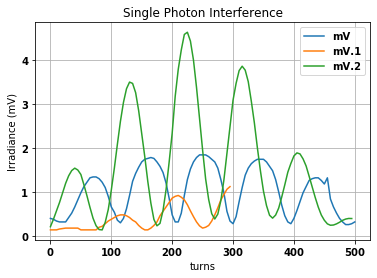

In [97]:
df_laser = pd.read_excel("quantitative data.xlsx", "laser, both slits")
# df_laser
# df_laser.plot("turns", "mV", grid=True)
# df_laser.plot("turns.1", "mV.1", grid=True)
# df_laser.plot("turns.2", "mV.2", grid=True)
p = df_laser.plot("turns", ["mV", "mV.1", "mV.2"], grid=True)
p.axes.set_title("Single Photon Interference");
p.axes.set_ylabel("Irradiance (mV)");


I0 = 1.720 \pm 0.075	mV 
x0 = 253.167 \pm 0.469
L  = 51.606 \pm 96427.704	cm
l  = 670.691 \pm 20344069.574	nm
a  = 0.077 \pm 2343.188	mm
d  = 0.372 \pm 11250.502	mm
C  = 0.426 \pm 0.046	mV 


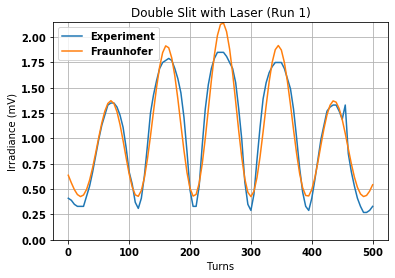

In [98]:
fig, ax = plt.subplots(1, 1);
turns1 = df_laser["turns"][0:101].to_numpy()
mV1 = df_laser["mV"][0:101].to_numpy()
p1, pc1 = myplot(turns1, mV1, "Double Slit with Laser (Run 1)", fig, ax)

I0 = 4.391 \pm 0.076	mV 
x0 = 223.417 \pm 0.198
L  = 46.215 \pm 31920.667	cm
l  = 668.137 \pm 13589556.835	nm
a  = 0.091 \pm 1851.404	mm
d  = 0.328 \pm 6657.364	mm
C  = 0.270 \pm 0.047	mV 


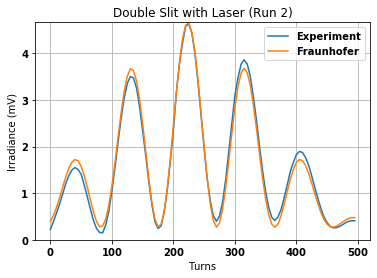

In [99]:
fig, ax = plt.subplots(1, 1);
turns2 = df_laser["turns.2"][0:100].to_numpy()
mV2 = df_laser["mV.2"][0:100].to_numpy()
p2, pc2 = myplot(turns2, mV2, "Double Slit with Laser (Run 2)", fig, ax)

I0 = 1.012 \pm 0.014	mV 
x0 = 299.018 \pm 0.336
L  = 46.660 \pm 21417.726	cm
l  = 668.144 \pm 11901425.099	nm
a  = 0.094 \pm 1675.113	mm
d  = 0.333 \pm 5930.520	mm
C  = 0.161 \pm 0.009	mV 


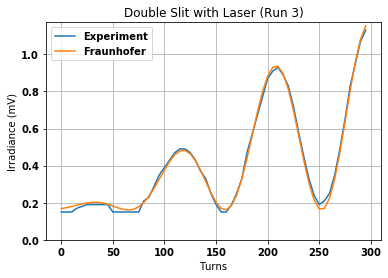

In [100]:
fig, ax = plt.subplots(1, 1);
turns3 = df_laser["turns.1"][0:60].to_numpy()
mV3 = df_laser["mV.1"][0:60].to_numpy()
p3, pc3 = myplot(turns3, mV3, "Double Slit with Laser (Run 3)", fig, ax)

In [101]:
popt = (p1+p2+p3)/3
perr = np.std(np.stack((p1, p2, p3)), 0)
# print(perr)

print(f'''I0 = {popt[0]:.3f} \pm {perr[0]:.3f}\tmV 
x0 = {popt[1]:.3f} \pm {perr[1]:.3f}
L  = {popt[2]:.3f} \pm {perr[2]:.3f}\tcm
l  = {popt[3]:.3f} \pm {perr[3]:.3f}\tnm
a  = {popt[4]:.3f} \pm {perr[4]:.3f}\tmm
d  = {popt[5]:.3f} \pm {perr[5]:.3f}\tmm
C  = {popt[6]:.3f} \pm {perr[6]:.3f}\tmV ''')

I0 = 2.374 \pm 1.455	mV 
x0 = 258.534 \pm 31.097
L  = 48.161 \pm 2.443	cm
l  = 668.991 \pm 1.203	nm
a  = 0.088 \pm 0.007	mm
d  = 0.344 \pm 0.020	mm
C  = 0.286 \pm 0.109	mV 


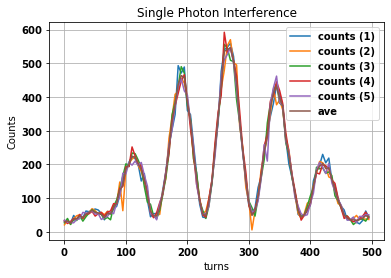

In [102]:
df_single = pd.read_excel("quantitative data.xlsx", "single  photon")
# df_single
p = df_single.plot("turns", ["counts (1)", "counts (2)", "counts (3)", "counts (4)", "counts (5)", "ave"], grid=True);
p.axes.set_title("Single Photon Interference");
p.axes.set_ylabel("Counts");

# df_single.plot("turns", "ave", yerr="stddev", grid=True)


In [103]:
turns_single = df_single["turns"].to_numpy()
counts1 = df_single["counts (1)"].to_numpy()
counts2 = df_single["counts (2)"].to_numpy()
counts3 = df_single["counts (3)"].to_numpy()
counts4 = df_single["counts (4)"].to_numpy()
counts5 = df_single["counts (5)"].to_numpy()
countsAve = (counts1+counts2+counts3+counts4+counts5)/5


I0 = 532.272 \pm 11.616	mV 
x0 = 267.199 \pm 0.254
L  = 48.107 \pm 39109.018	cm
l  = 541.718 \pm 9336087.045	nm
a  = 0.093 \pm 1603.455	mm
d  = 0.327 \pm 5656.161	mm
C  = 37.986 \pm 4.283	mV 
I0 = 539.040 \pm 14.801	mV 
x0 = 266.990 \pm 0.338
L  = 48.461 \pm 54979.052	cm
l  = 542.939 \pm 10971684.848	nm
a  = 0.093 \pm 1870.934	mm
d  = 0.333 \pm 6678.620	mm
C  = 30.000 \pm 4.620	mV 
I0 = 531.738 \pm 11.284	mV 
x0 = 267.344 \pm 0.253
L  = 47.397 \pm 42928.511	cm
l  = 541.302 \pm 9256671.820	nm
a  = 0.092 \pm 1563.553	mm
d  = 0.323 \pm 5482.647	mm
C  = 36.202 \pm 4.113	mV 
I0 = 537.493 \pm 9.945	mV 
x0 = 267.316 \pm 0.222
L  = 47.563 \pm 39397.579	cm
l  = 540.962 \pm 7933916.629	nm
a  = 0.093 \pm 1354.702	mm
d  = 0.322 \pm 4712.171	mm
C  = 39.635 \pm 3.564	mV 
I0 = 519.393 \pm 10.695	mV 
x0 = 267.610 \pm 0.243
L  = 48.118 \pm 33621.306	cm
l  = 542.013 \pm 8882854.639	nm
a  = 0.093 \pm 1524.602	mm
d  = 0.327 \pm 5363.370	mm
C  = 38.217 \pm 3.955	mV 
I0 = 529.882 \pm 8.009	mV 
x0 = 267.308 

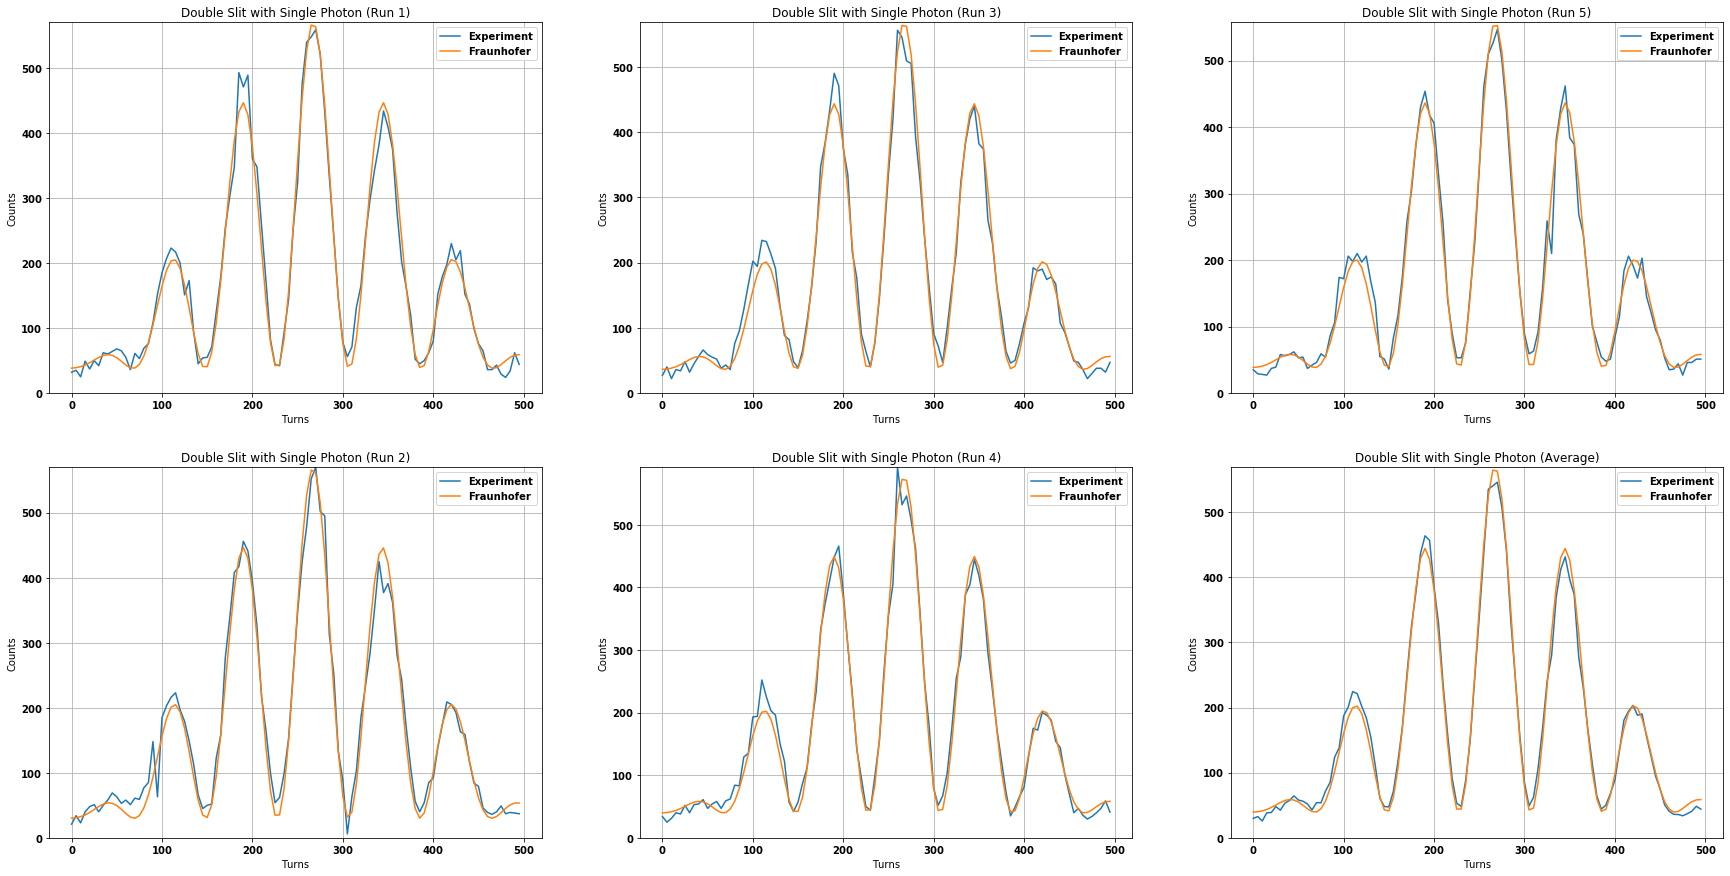

In [104]:
fig, axs = plt.subplots(2, 3, figsize=(30,15))
p1_sing, pc1_sing = myplot(turns_single, counts1, "Double Slit with Single Photon (Run 1)", fig, axs[0,0])
p2_sing, pc2_sing = myplot(turns_single, counts2, "Double Slit with Single Photon (Run 2)", fig, axs[1,0])
p3_sing, pc3_sing = myplot(turns_single, counts3, "Double Slit with Single Photon (Run 3)", fig, axs[0,1])
p4_sing, pc4_sing = myplot(turns_single, counts4, "Double Slit with Single Photon (Run 4)", fig, axs[1,1])
p5_sing, pc5_sing = myplot(turns_single, counts5, "Double Slit with Single Photon (Run 5)", fig, axs[0,2])
pave_sing, pcave_sing = myplot(turns_single, countsAve, "Double Slit with Single Photon (Average)", fig, axs[1,2])



In [105]:
popt = (p1_sing+p2_sing+p3_sing+p4_sing+p5_sing+pave_sing)/6
perr = np.std(np.stack((p1_sing,p2_sing,p3_sing,p4_sing,p5_sing,pave_sing)), 0)
# print(perr)

print(f'''I0 = {popt[0]:.3f} \pm {perr[0]:.3f}\tmV 
x0 = {popt[1]:.3f} \pm {perr[1]:.3f}
L  = {popt[2]:.3f} \pm {perr[2]:.3f}\tcm
l  = {popt[3]:.3f} \pm {perr[3]:.3f}\tnm
a  = {popt[4]:.3f} \pm {perr[4]:.3f}\tmm
d  = {popt[5]:.3f} \pm {perr[5]:.3f}\tmm
C  = {popt[6]:.3f} \pm {perr[6]:.3f}\tmV ''')

I0 = 531.637 \pm 6.357	mV 
x0 = 267.294 \pm 0.185
L  = 47.918 \pm 0.358	cm
l  = 541.657 \pm 0.684	nm
a  = 0.093 \pm 0.000	mm
d  = 0.326 \pm 0.003	mm
C  = 36.901 \pm 3.281	mV 
